<function matplotlib.pyplot.show(close=None, block=None)>

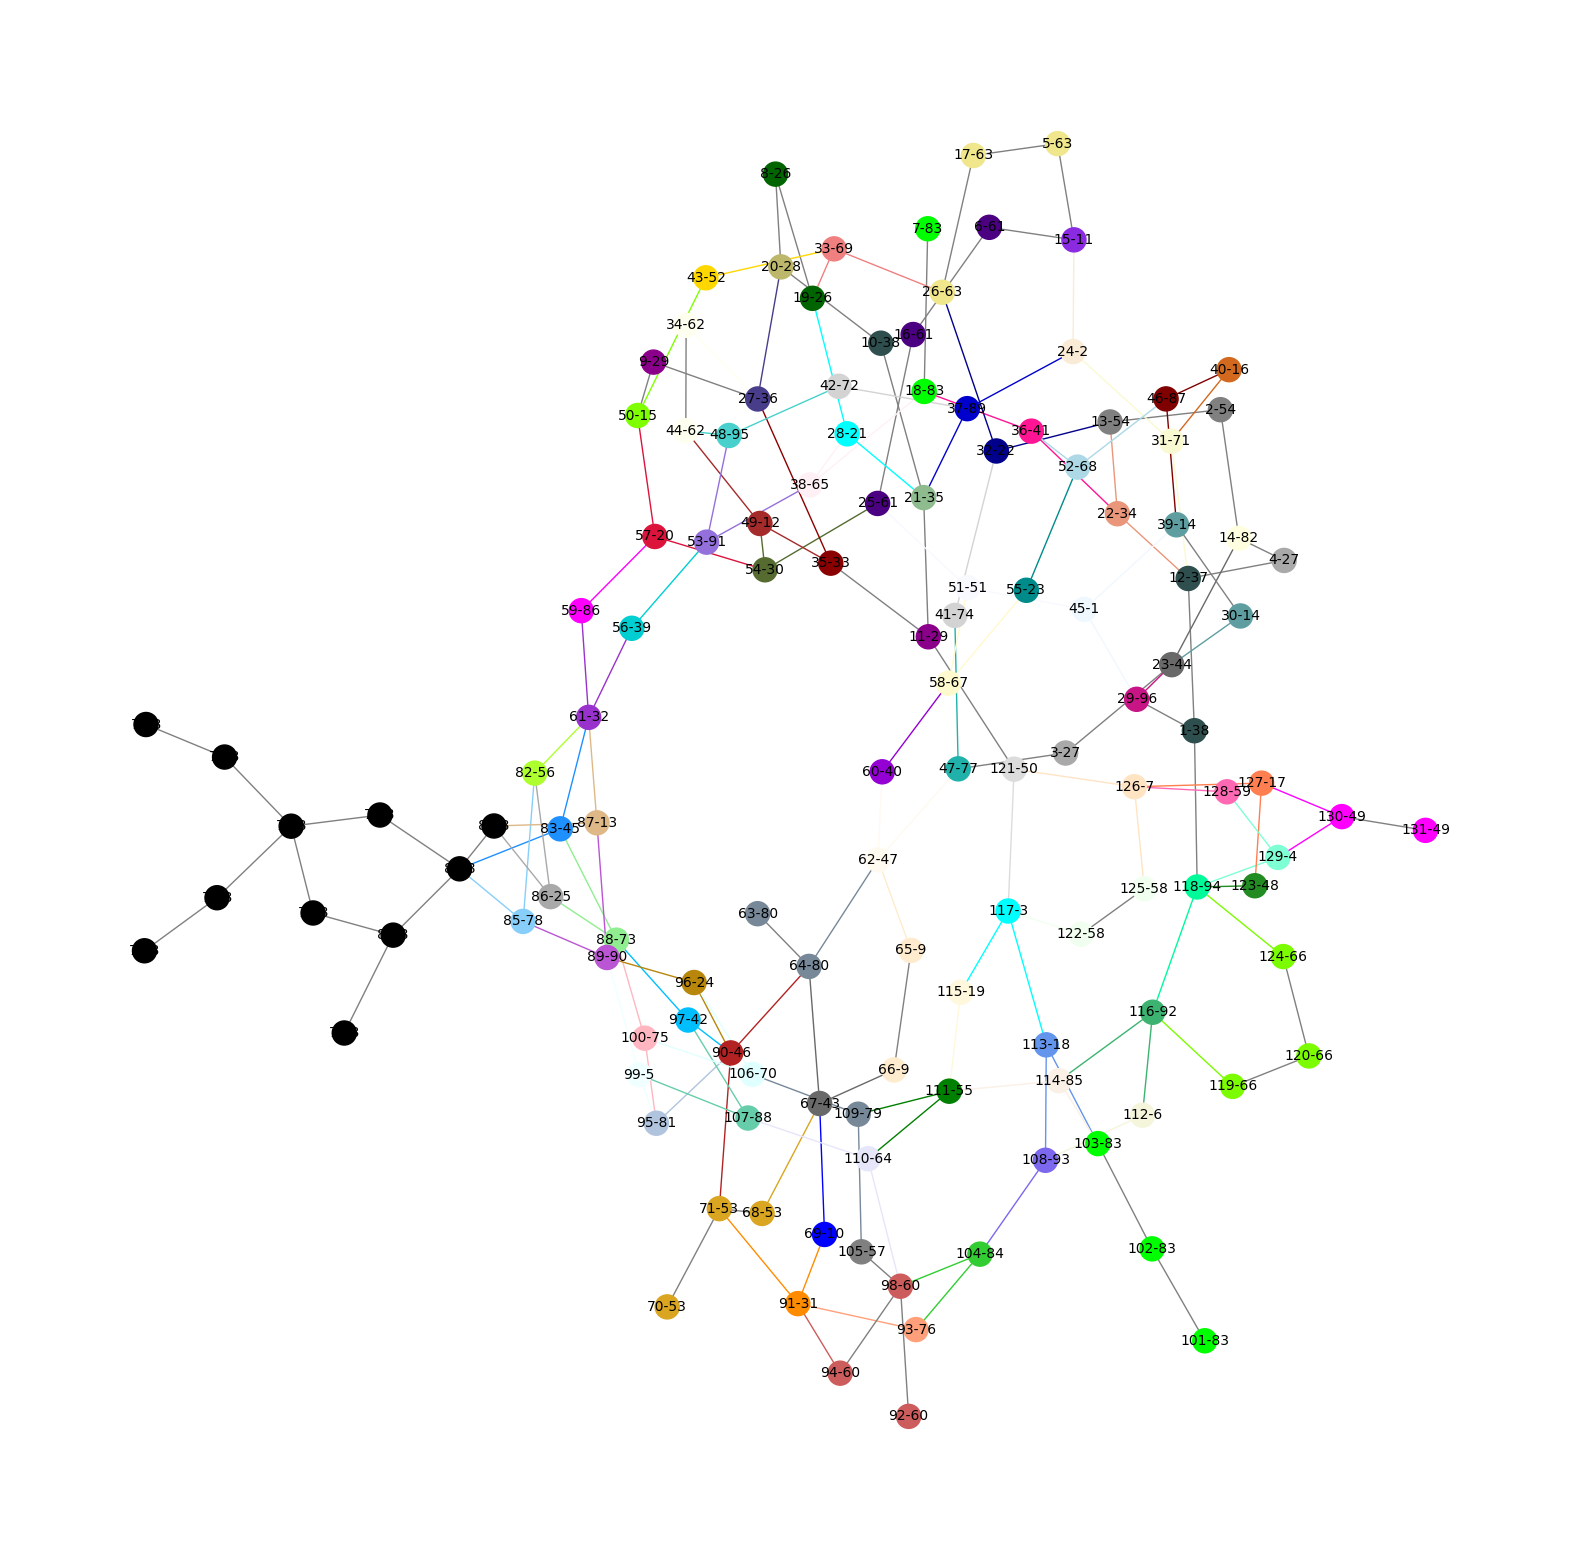

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Read in the data from the files
with open('circuit_data/circuit.txt', 'r') as node_file:
    node_lines = node_file.readlines()

with open('results/nodes/max_nodes_11_max_channels_4_num_cells_96_1680905914033', 'r') as group_file:
    group_lines = group_file.readlines()

with open('results/channels/max_nodes_11_max_channels_4_num_cells_96_1680905914033', 'r') as color_file:
    color_data = eval(color_file.read())

# Create the graph
graph = nx.Graph()

# Iterate over the node data and add nodes and edges to the graph
input_nodes = []
output_nodes = []
for line in node_lines:
    values = line.strip().split(';')
    if len(values) < 3:
        continue
    if not values[1].isdigit():
        continue
    node_id = int(values[1])
    input_ids = [int(x) for x in values[2].split(',') if x.isdigit()]
    graph.add_node(node_id, label=node_id)
    for input_id in input_ids:
        graph.add_edge(input_id, node_id)
        if input_id not in input_nodes:
            input_nodes.append(input_id)
        if node_id not in output_nodes:
            output_nodes.append(node_id)

# Generate a list of distinct colors based on the number of groups
num_groups = len(group_lines)
color_list = list(mcolors.CSS4_COLORS.values())
color_list = color_list[::int(len(color_list) / num_groups)]
color_list = color_list[:num_groups]

# Assign a unique color and group ID to each group
node_group = {}
for i, line in enumerate(group_lines):
    node_ids = [int(x) for x in line.strip().split(',') if x.isdigit()]
    color = color_list[i % num_groups] # cycle through the set of colors
    for node_id in node_ids:
        graph.nodes[node_id]['color'] = color
        node_group[node_id] = i + 1 # add 1 to group ID to avoid 0 indexing

# Add group ID to node labels
for node_id in graph.nodes():
    label = str(node_id)
    if node_id in node_group:
        label += '-' + str(node_group[node_id])
    graph.nodes[node_id]['label'] = label

# Assign a color to each edge based on the output node color
edge_colors = []
for edge in graph.edges():
    color = 'gray' # default edge color
    if edge[0] in output_nodes and edge[1] in output_nodes:
        if node_group[edge[0]] != node_group[edge[1]]:
            output_node = edge[1] # get the output node
            if 'color' in graph.nodes[output_node]:
                color = graph.nodes[output_node]['color'] # use the output node color
    edge_colors.append(color)

# Draw the graph
pos = nx.kamada_kawai_layout(graph)
node_colors = {node_id: graph.nodes[node_id]['color'] for node_id in graph.nodes()}
node_labels = nx.get_node_attributes(graph, 'label')

fig, ax = plt.subplots(figsize=(20, 20))
nx.draw_networkx_nodes(graph, pos, node_color=list(node_colors.values()), ax=ax)
nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, ax=ax)
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=10, ax=ax)
ax.set_axis_off()
plt.show


In [52]:
def validate_groups(group_file, node_lines, max_gates_per_cell, max_total_num_channels, channel_dict):
    # Read in the group data from the file
    with open(group_file, 'r') as f:
        group_lines = f.readlines()

    # Create a dictionary to keep track of the total number of channels connected to each group
    channel_counts = {i + 1: {} for i in range(len(group_lines))}

    # Create a dictionary to keep track of which gates output to other gates within the same group
    intra_group_outputs = {i + 1: [] for i in range(len(node_lines))}

    # Update the dictionary based on the group data
    for i, line in enumerate(group_lines):
        node_ids = [int(x) for x in line.strip().split(',') if x.isdigit()]
        for node_id in node_ids:
            if node_id not in intra_group_outputs:
                raise ValueError(f"Invalid gate ID: {node_id}")
            intra_group_outputs[node_id].extend(node_ids)

    # Iterate over the node data and count the number of channels connected to each group
    for line in node_lines:
        values = line.strip().split(';')
        if len(values) < 3:
            continue
        if not values[1].isdigit():
            continue
        node_id = int(values[1])
        input_ids = [int(x) for x in values[2].split(',') if x.isdigit()]
        output = False
        for input_id in input_ids:
            if input_id not in intra_group_outputs:
                raise ValueError(f"Invalid gate ID: {input_id}")
            if input_id in channel_counts:
                channel_counts[input_id][node_id] = True
                output = True
        if output:
            if node_id not in intra_group_outputs:
                raise ValueError(f"Invalid gate ID: {node_id}")
            if node_id in channel_counts:
                for k in channel_counts[node_id].keys():
                    if k in channel_counts and k != node_id:
                        if k not in intra_group_outputs[node_id]:
                            return [i + 1 for i, line in enumerate(group_lines)]

                channel_counts[node_id][node_id] = True

    # Check if each group is valid
    invalid_groups = []
    for i, line in enumerate(group_lines):
        node_ids = [int(x) for x in line.strip().split(',') if x.isdigit()]
        if len(node_ids) > max_gates_per_cell:
            invalid_groups.append(i + 1)
        total_channels = len(channel_counts[i + 1])
        if total_channels > max_total_num_channels:
            invalid_groups.append(i + 1)

    # Check if channels are assigned correctly
    for node_id, color in channel_dict.items():
        if node_id in intra_group_outputs[node_id]:
            invalid_groups.append(i + 1)

    return invalid_groups


In [53]:
MAX_GATES_PER_CELL = 11
MAX_TOTAL_NUM_CHANNELS = 4

if validate_groups('results/nodes/max_nodes_11_max_channels_4_num_cells_96_1680905914033', node_lines, MAX_GATES_PER_CELL, MAX_TOTAL_NUM_CHANNELS, color_data):
    print('All groups are valid!')
else:
    print('Some groups are invalid.')


All groups are valid!
